In [2]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', 100)

import os

import numpy as np
import matplotlib.pyplot as plt

In [10]:
calves = pd.read_csv('sample cleaned/breedings.csv')
calves.calving_date = pd.to_datetime(calves.calving_date, errors='coerce')
calves

,cow_id,lactation_number,calving_date,event
0,1,3,2018-06-04,BRED
1,1,4,2019-06-09,BRED
2,2,2,2018-06-04,BRED
3,4,2,2018-07-08,BRED
4,6,2,2019-01-01,BRED
...,...,...,...,...
2677,13528,0,2018-11-25,BRED
2678,13536,0,2018-11-26,BRED
2679,13537,0,2018-11-27,BRED
2680,13560,0,2018-12-05,BRED


In [17]:
cows = dict()
for file_name in os.listdir('sample cleaned/'):
    if file_name != 'breedings.csv' and file_name.split('.')[1] == 'csv':
        cow_id = int(file_name.split('.')[0])
        cows[cow_id] = pd.read_csv('sample cleaned/' + file_name)
        cows[cow_id].time = pd.to_datetime(cows[cow_id].time, errors='coerce')

In [7]:
DAY = 24*6

HEAT_MIN = 8*6
HEAT_MAX = 30*6

CYCLE_MIN = 21*24*6
CYCLE_MAX = 21*24*6

In [8]:
relevant_cols = ['act_heat_index_smart', 'activity', 'activity_1day_avg', '60percentile_of_5day_temp', 
                 'temp_height_index', 'temp_inc_index', 'temp_without_drink_cycles']

In [21]:
def get_maxes(df):
    df_diff = df[relevant_cols] - df[relevant_cols].rolling(CYCLE_MIN, min_periods=1).mean().shift(periods=DAY, fill_value=0)
    return df_diff.abs().rolling(DAY, min_periods=1).max().max(axis=1)


def plot_cow(df, cow_id):
    ax = plt.gca()
        
    dates = (min(df.time), max(df.time))
    df.plot(kind='line', x='time', y='temp_without_drink_cycles', ax=ax, figsize=(30, 10), xticks=np.arange(dates[0], dates[1], pd.Timedelta(days=21)))
    df.plot(kind='line', x='time', y='activity_1day_avg', color='green', ax=ax)
    df.plot(kind='line', x='time', y='activity', color='red', ax=ax)
    
    maxes = get_maxes(df)
    
    results = dict()
    for i in range(CYCLE_MIN):
        results[i] = 0
        j = i
        while j < len(df):
            m = maxes.loc[j]
            results[i] += m
            j += DAY + CYCLE_MIN
            
    result = max(results.items(), key=lambda x: x[1])
    for x in range(result[0], len(df)-DAY, DAY+CYCLE_MIN):
        ax.axvline(df.time.iloc[x], color='red')
        ax.axvline(df.time.iloc[x+DAY], color='red')
    
    for date in calves[calves.cow_id == cow_id].calving_date:
        pregnancy = (date - pd.Timedelta(days=283), date)
        if pregnancy[1] > dates[0] and pregnancy[0] < dates[1]:
            ax.axvspan(pregnancy[0], pregnancy[1], color='purple', alpha=0.25)

    print(cow_id)
    plt.show()

10666


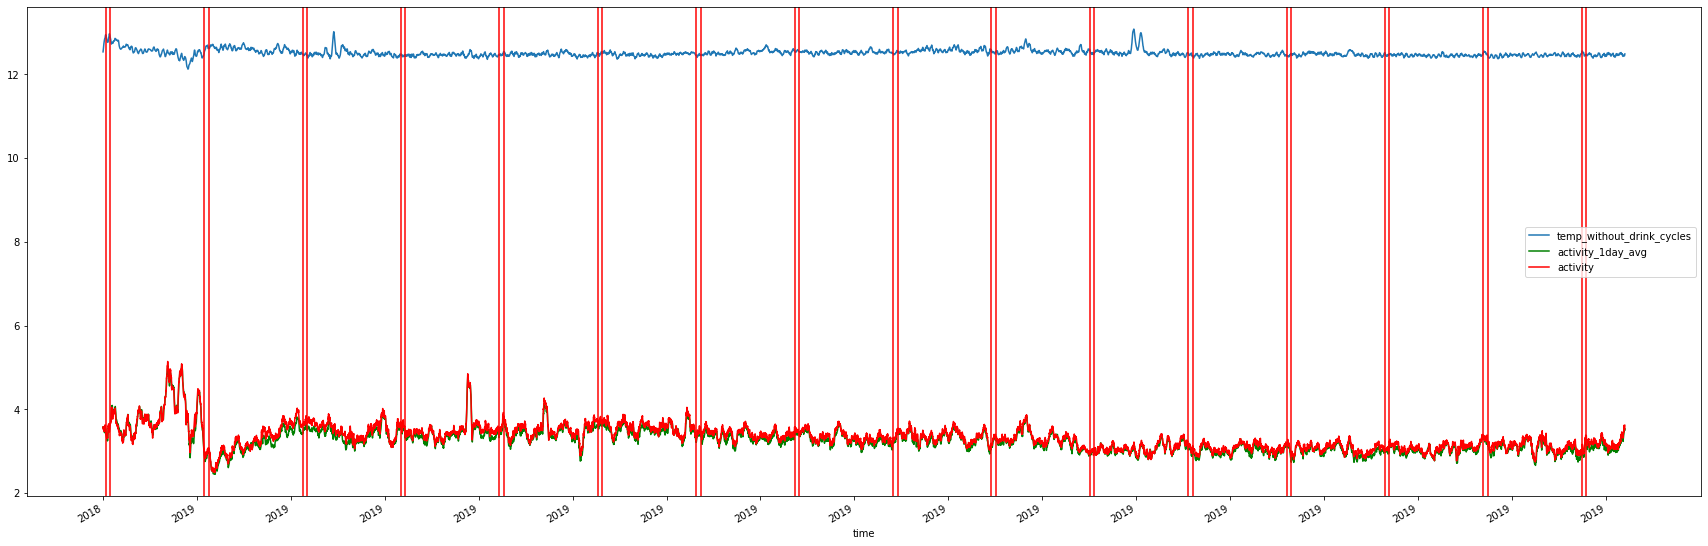

9997


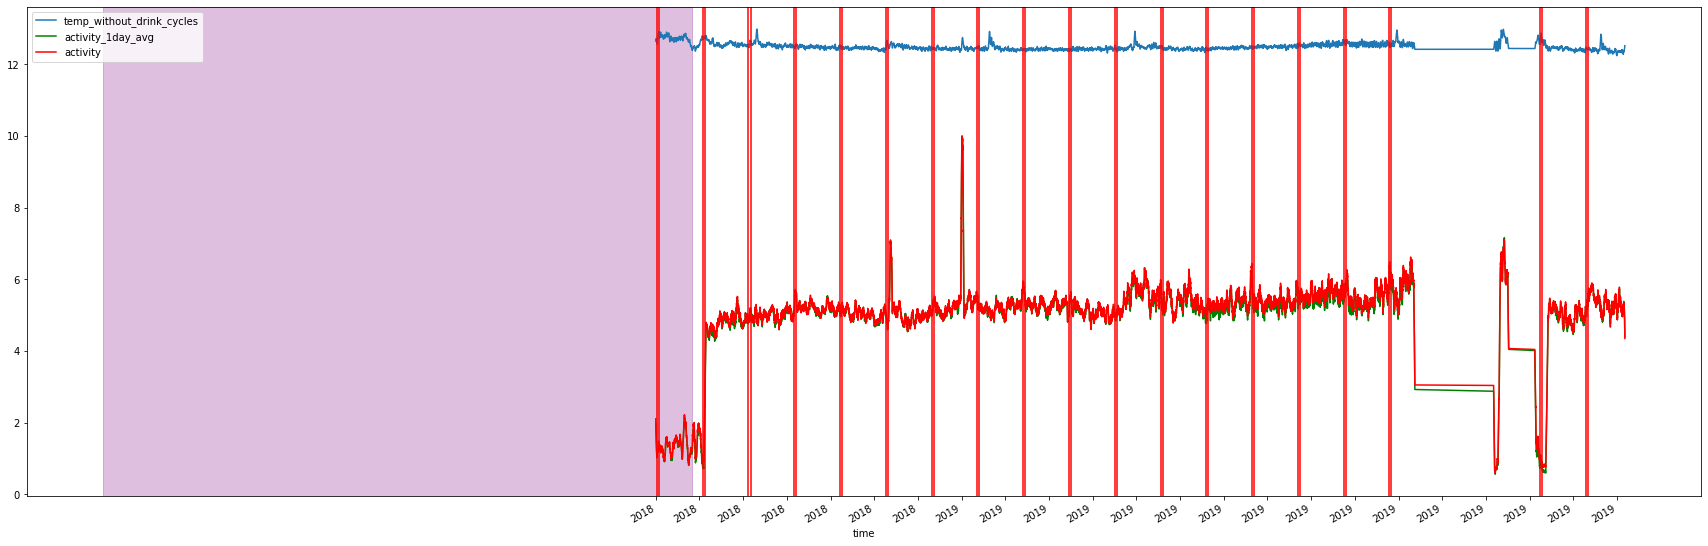

9994


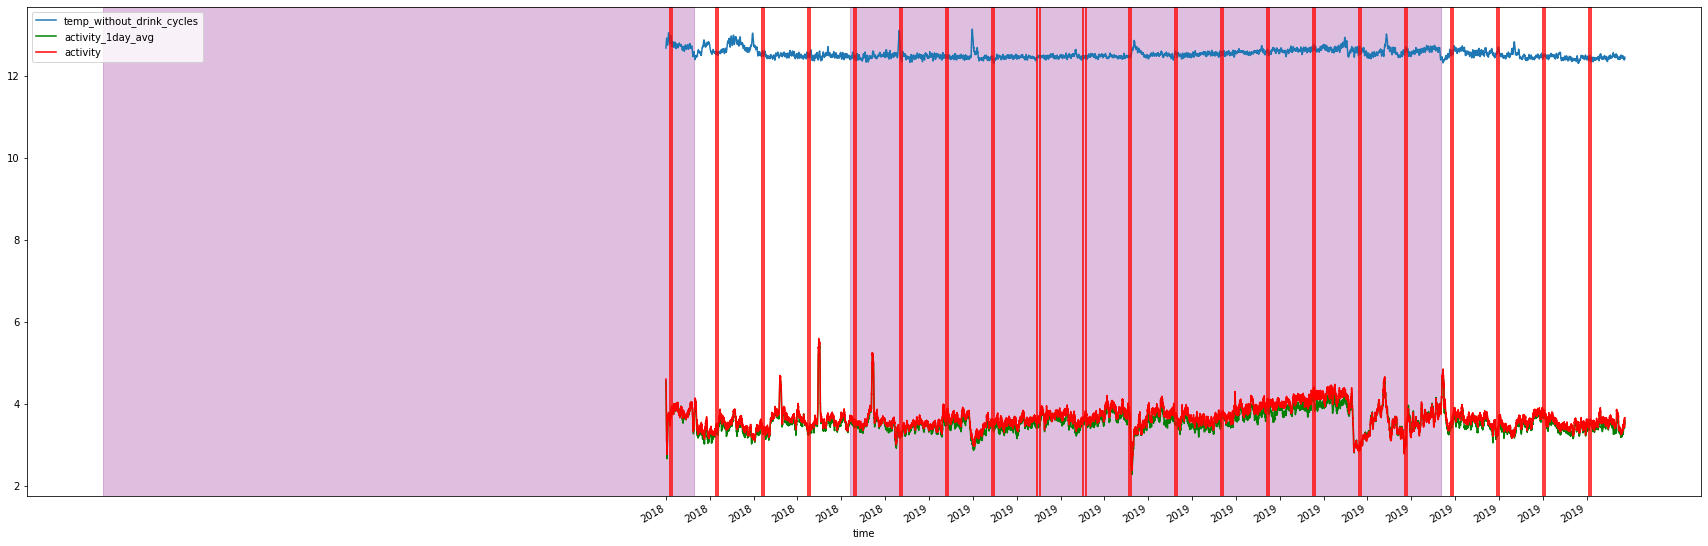

9995


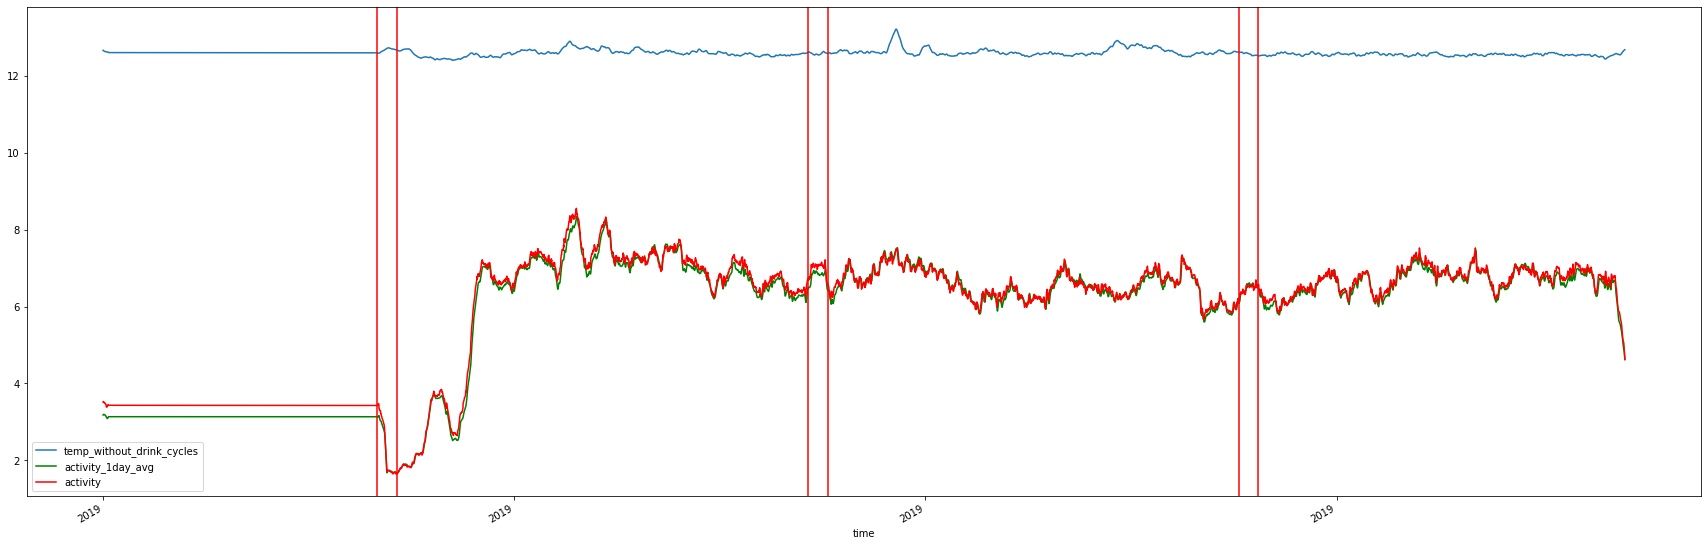

9992


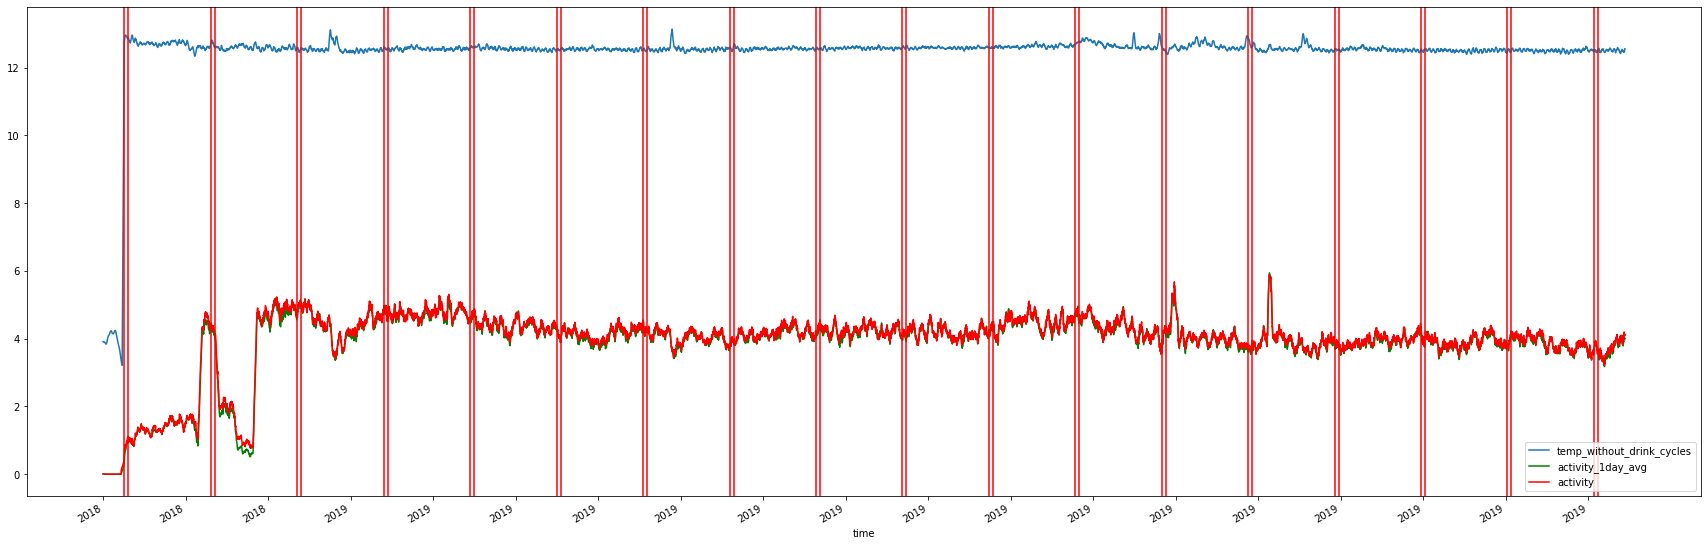

9993


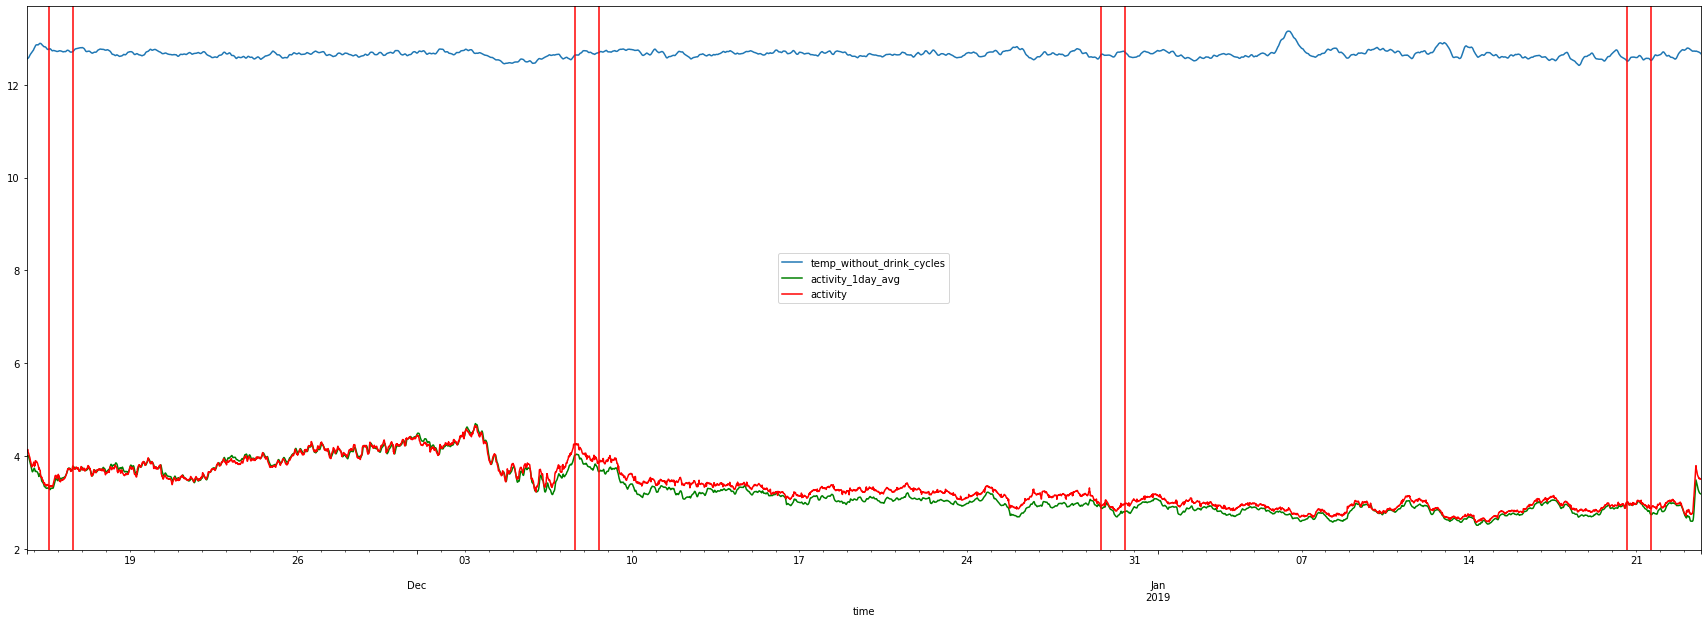

10787


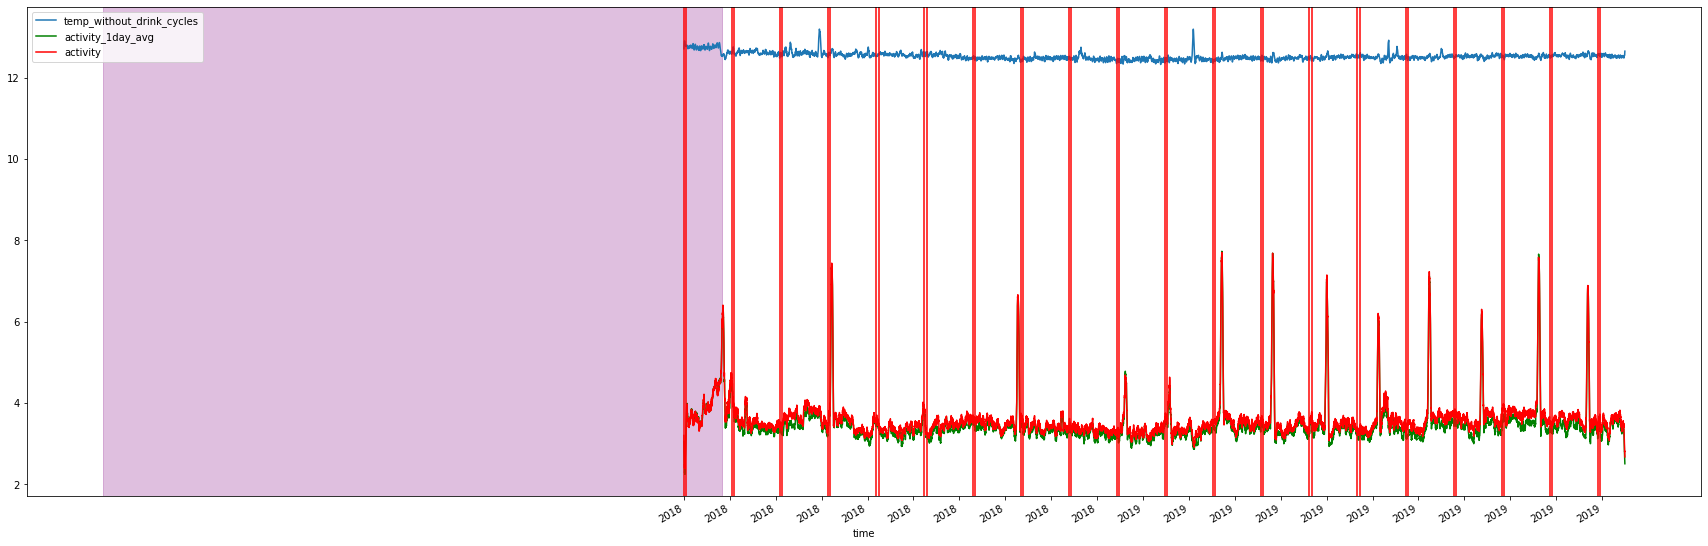

9975


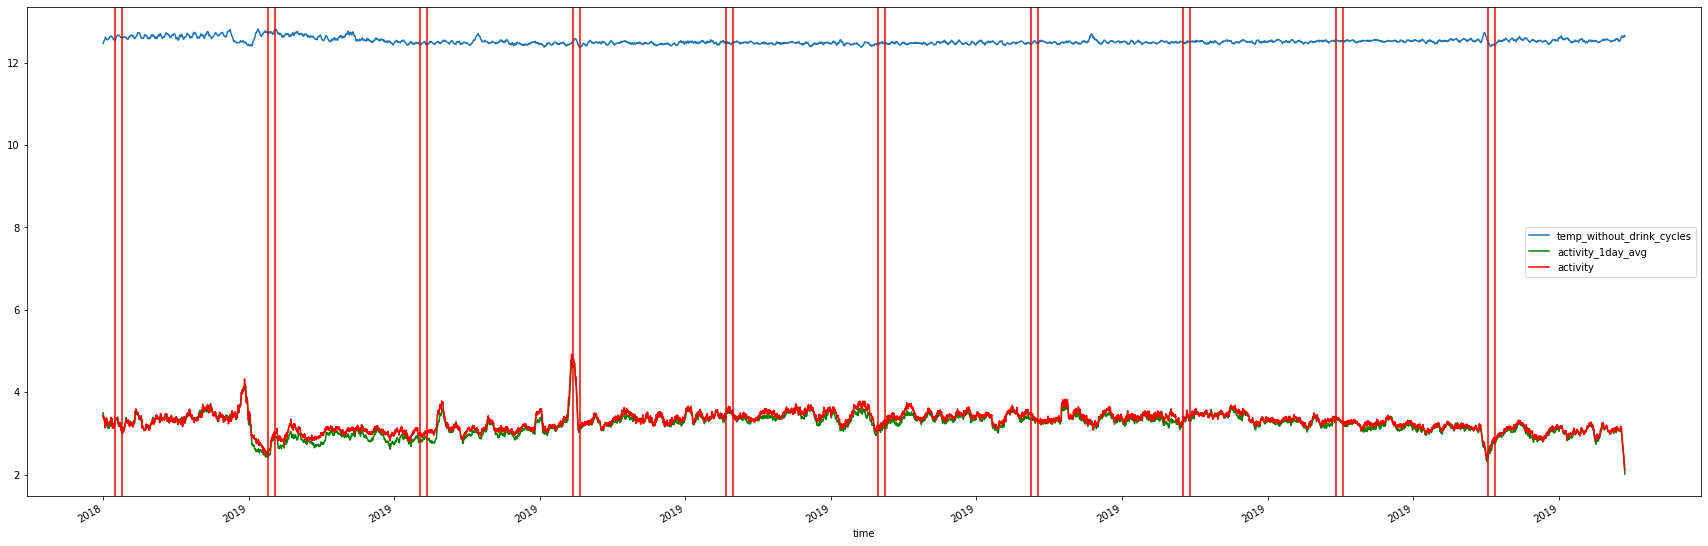

10785


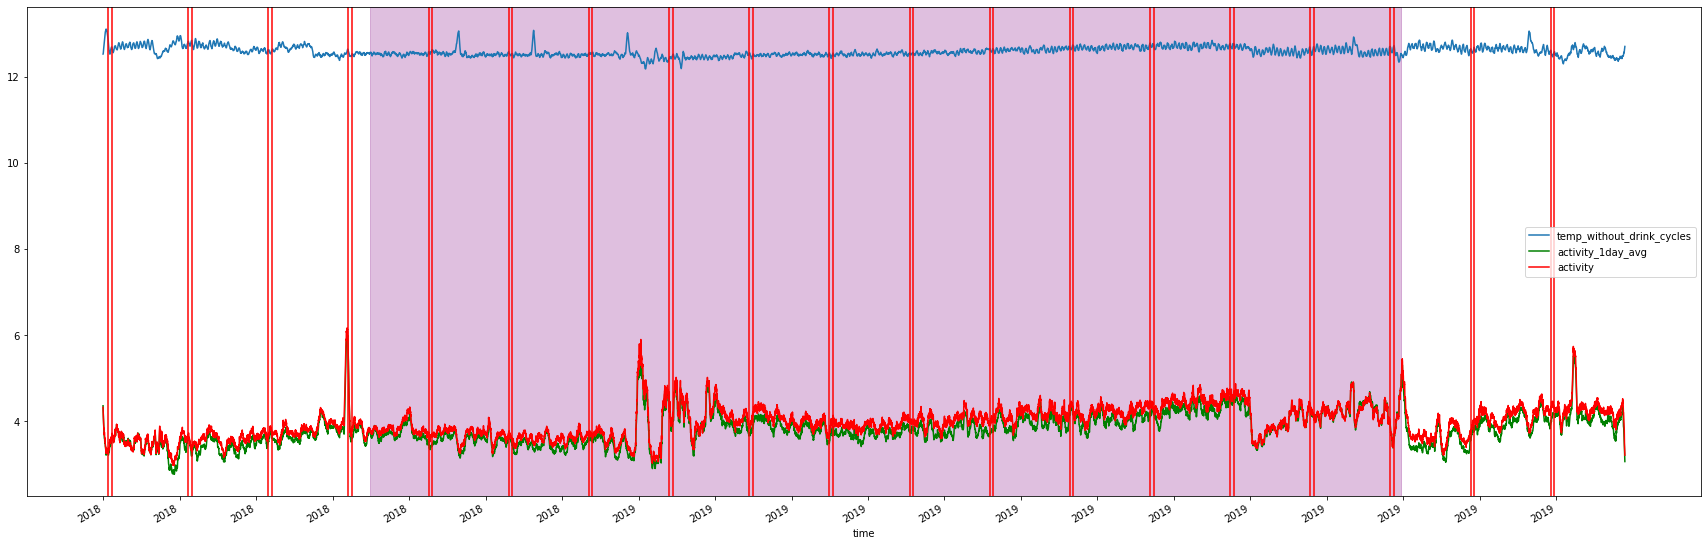

10


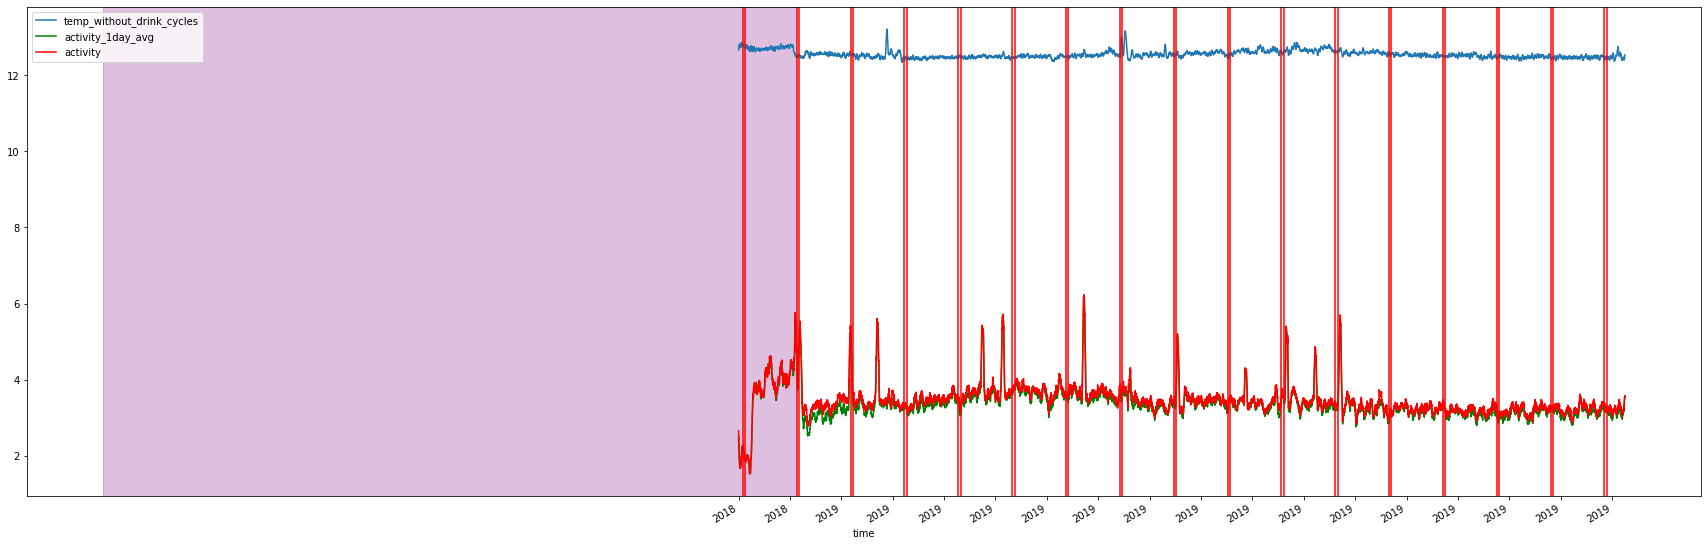

In [22]:
for cow in cows.keys():
    plot_cow(cows[cow], cow)